# Style transfer using graph cuts

reimplementation of the paper : https://arxiv.org/pdf/1904.04443.pdf

Antoine Debouchage, Thomas Lemercier, Gaspard Berthelier

## Imports

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

%cd /content/drive/MyDrive/GRM_proj/

# import os
# import sys
# sys.path.insert(0, "../")
# sys.path.insert(0, "../..")

Mounted at /content/drive
/content/drive/MyDrive/GRM_proj


In [2]:
!pip install PyMaxflow
!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.4/798.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.5 MB/s eta 0:00:00


In [3]:
from PIL import Image
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from time import perf_counter

In [4]:
from src.energy import style_transfer
import src.graph_cut as gc
from maxflow.fastmin import aexpansion_grid

## Data

Content shape :  (128, 128, 3)
Style shape :  (128, 128, 3)


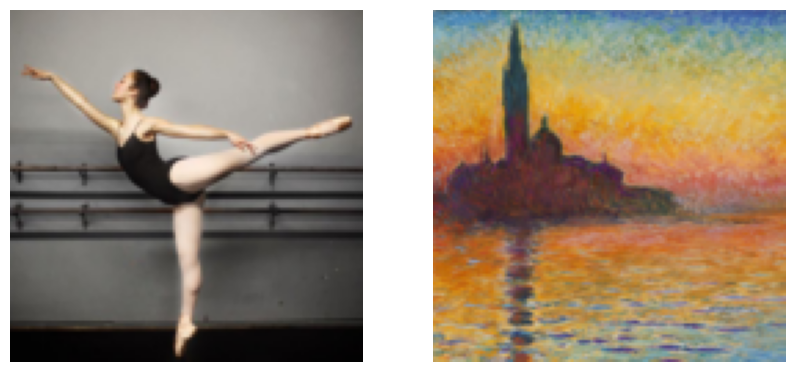

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name, for_plot=True):
    image = Image.open(image_name)
    image =  loader(image).unsqueeze(0).to(device, torch.float)[:, :3][0]
    if for_plot:
      image = image.cpu().numpy().transpose(1,2,0)
    return image


# content_img = image_loader("../data/images/dance2.png")
# style_img = image_loader("../data/images/monnet.png")
content_img = image_loader("data/content/dance2.png")
style_img = image_loader("data/style/monnet.png")

print("Content shape : ",content_img.shape)
print("Style shape : ",style_img.shape)


def plot_2_images(content, style):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(content)
    ax[0].axis('off')
    ax[1].imshow(style)
    ax[1].axis('off')
    plt.show();

plot_2_images(content_img,style_img)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Transfered features shape :  torch.Size([3, 128, 128])


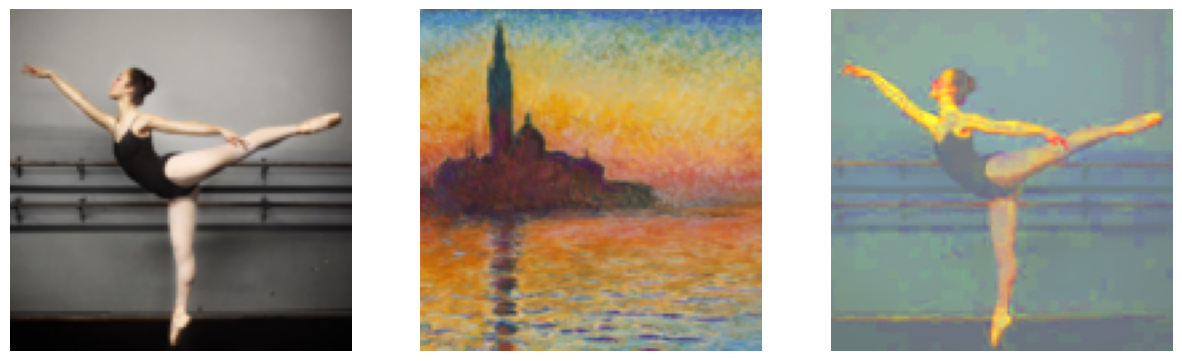

In [11]:
def plot_3_images(target, initial, assigned):
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(target)
    ax[0].axis('off')
    ax[1].imshow(initial)
    ax[1].axis('off')
    ax[2].imshow(assigned)
    ax[2].axis('off')
    plt.show();

#style transfer
n_clusters = 3
transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=1, lambd=1, k=n_clusters)
print("Transfered features shape : ",transfered_features.shape)
plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())

Content feature shapes :  (3, 128, 128)
Style feature shapes :  (3, 128, 128)
Cluster centers shape :  (3, 3)

Distance :  euclidean
Data term shape:  (128, 128, 3)
Greedy assignments shape :  (128, 128)
Distance image shape :  (128, 128)
mask shape:  (128, 128)


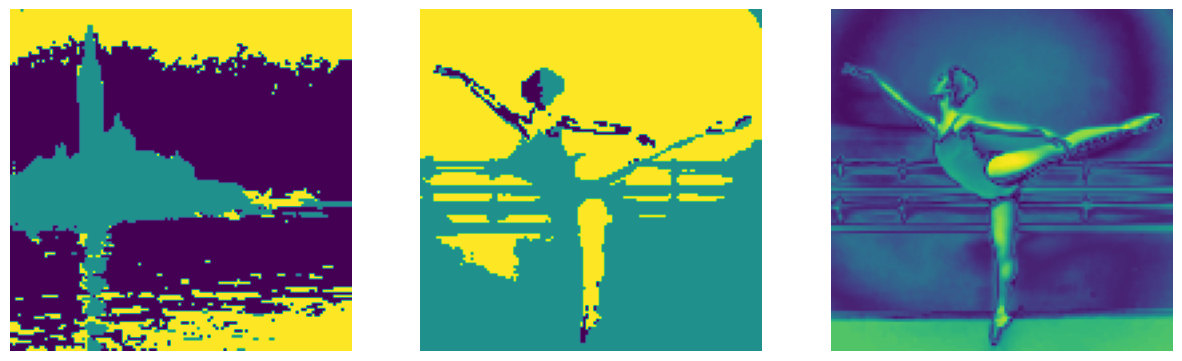


Distance :  cosine
Data term shape:  (128, 128, 3)
Greedy assignments shape :  (128, 128)
Distance image shape :  (128, 128)
mask shape:  (128, 128)


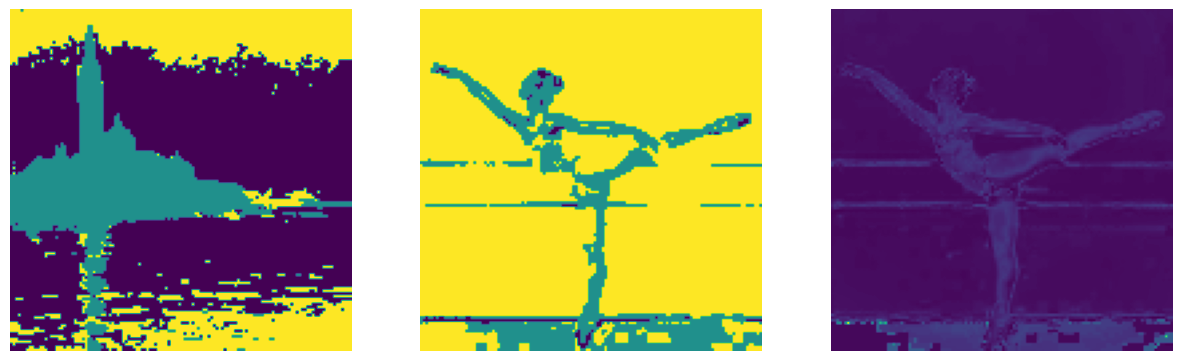

In [22]:
from src.energy import data_energy, cluster_style

content_features = content_img.transpose(2,0,1)
content_shape = content_features.shape # (channel, height, width)
style_features = style_img.transpose(2,0,1)
print("Content feature shapes : ",content_features.shape)
print("Style feature shapes : ",style_features.shape)
cluster_centers, cluster_list, cluster_labels = cluster_style(style_features, k = n_clusters)
print("Cluster centers shape : ",cluster_centers.shape)


for distance in ["euclidean","cosine",]:
  print("")
  print("Distance : ",distance)

  data_term = data_energy(content_features, cluster_centers, distance=distance)
  print("Data term shape: ",data_term.shape)

  greedy_assignments = np.argmin(data_term,axis=2)
  print("Greedy assignments shape : ",greedy_assignments.shape)

  distance_img = np.zeros((imsize,imsize),dtype=np.float32)
  print("Distance image shape : ",distance_img.shape)

  for i, cluster_center in enumerate(cluster_centers):
      mask = (greedy_assignments == i)
      if i==0: print("mask shape: ",mask.shape)
      distance_img[mask] = data_term[mask][:,i]

  plot_3_images(cluster_labels.reshape((imsize,imsize)), greedy_assignments, distance_img)

## Alpha expansion

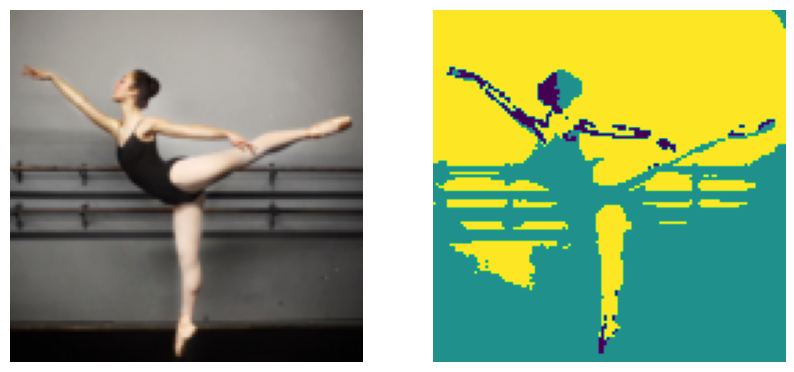

In [24]:
distance_array = data_energy(content_features, cluster_centers, distance="euclidean")
greedy_assignments = np.argmin(distance_array,axis=2)
plot_2_images(content_img,greedy_assignments)

Initial energy :  5151.8757783174515


  0%|          | 0/1000 [00:00<?, ?it/s]

Final energy :  5136.0979375094175
Mean number of fails :  110.22222222222223


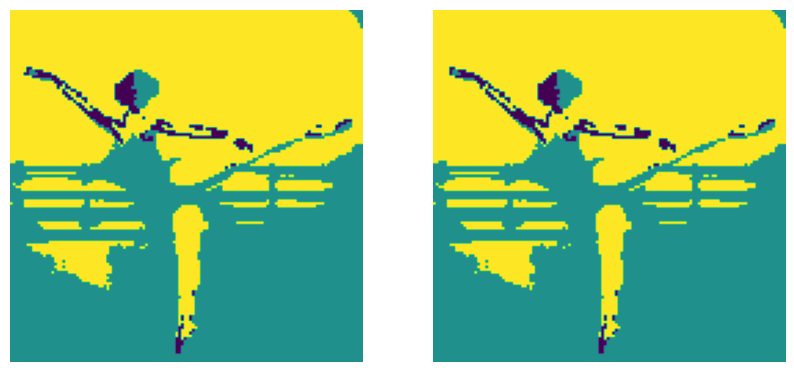

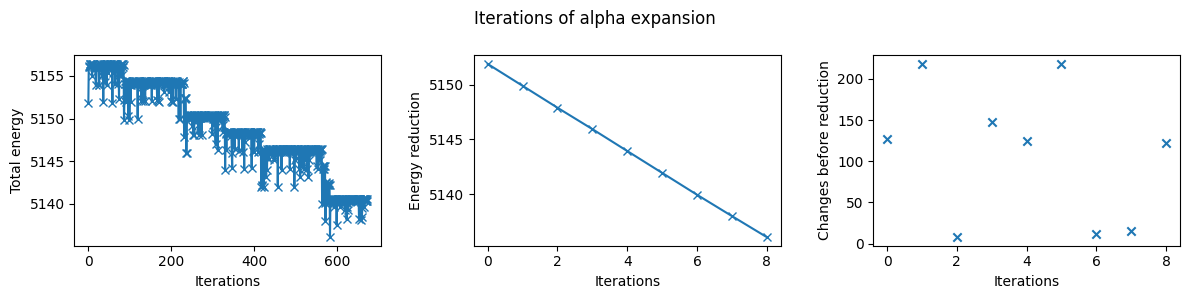

In [33]:
#stochastic expansion

lambd = 1
max_iter = 1000

assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_stochastic(distance_array, greedy_assignments, max_iter=max_iter, lambd=lambd)

print("Mean number of fails : ",np.mean(fail_counts))

plot_2_images(greedy_assignments, assignments)
gc.plot_energy(energies, computed_energies, fail_counts)

Initial energy :  5151.8757783174515


  0%|          | 0/1000 [00:00<?, ?it/s]

Final energy :  5143.396102800965
Mean number of fails :  199.2


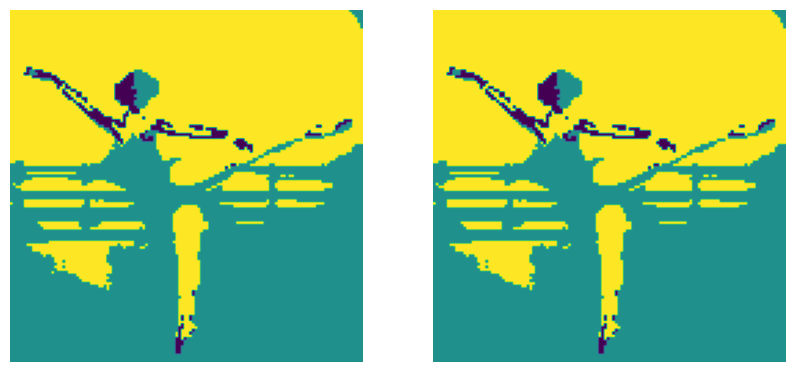

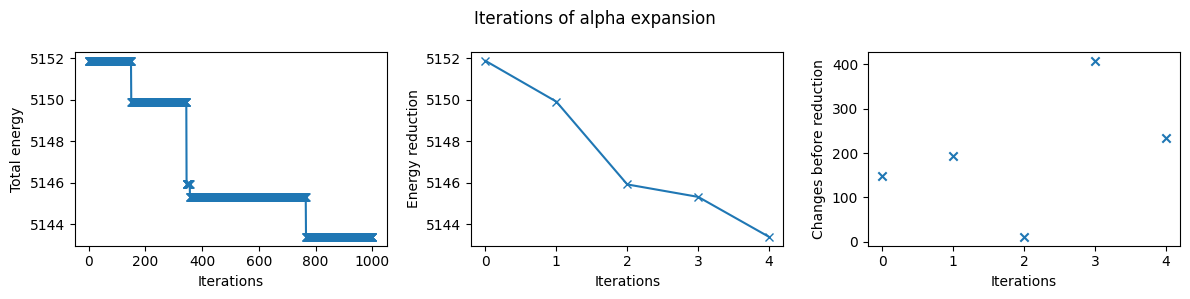

In [29]:
#greedy expansion

lambd = 1
max_iter = 1000
assignments, energies, fail_counts, computed_energies = gc.alpha_expansion_greedy(distance_array, greedy_assignments, max_iter=max_iter, lambd=lambd)

print("Mean number of fails : ",np.mean(fail_counts))

plot_2_images(greedy_assignments, assignments)
gc.plot_energy(energies, computed_energies, fail_counts)


lambda :  0.01


  0%|          | 0/30 [00:00<?, ?it/s]

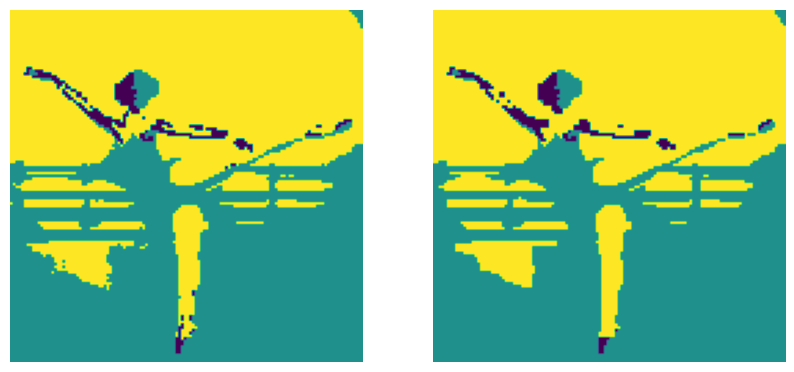

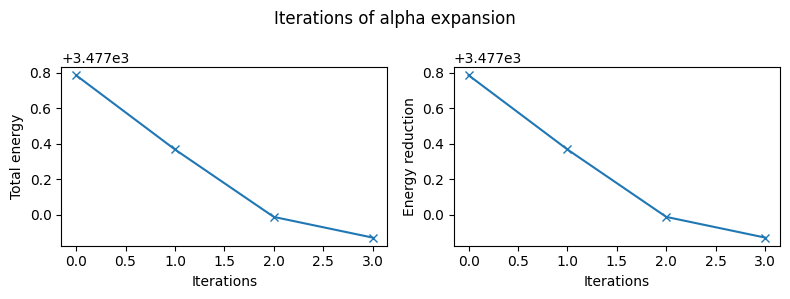


lambda :  0.1


  0%|          | 0/30 [00:00<?, ?it/s]

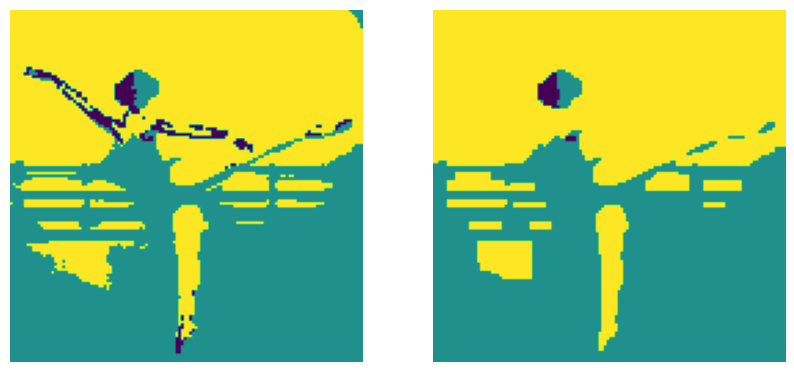

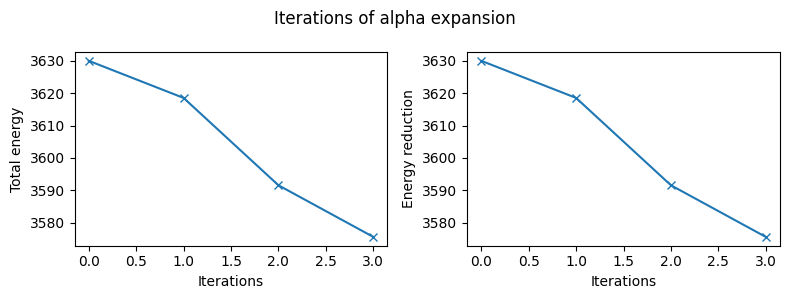


lambda :  1


  0%|          | 0/30 [00:00<?, ?it/s]

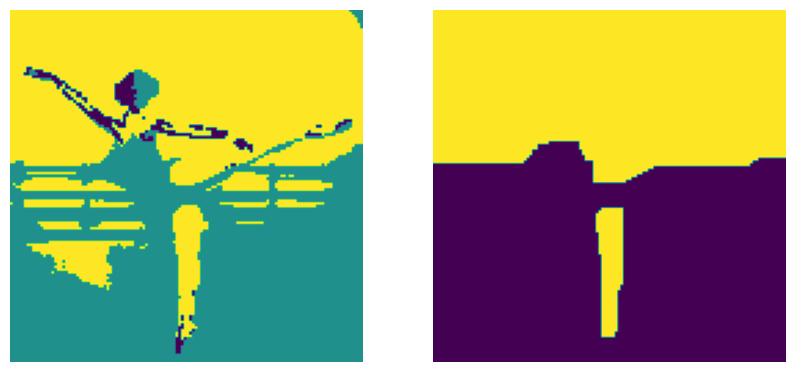

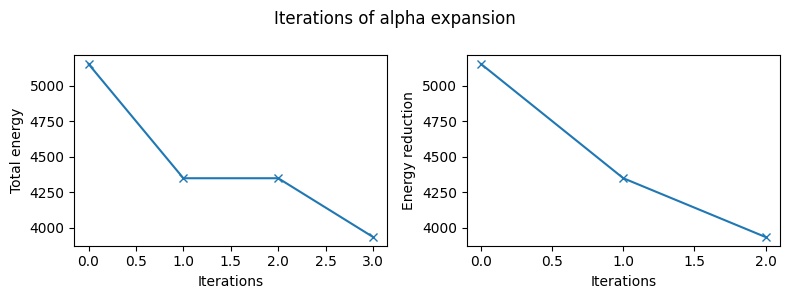

In [30]:
#our own alphaexpansion

for lambd in [1e-2,1e-1,1]:
  print("")
  print("lambda : ", lambd)

  assignments, energies, computed_energies = gc.alpha_expansion(distance_array, greedy_assignments, max_cycles=10, lambd=lambd)

  plot_2_images(greedy_assignments, assignments)
  gc.plot_energy(energies, computed_energies)


lambda :  0.01
Done in 0.02149048599994785 s


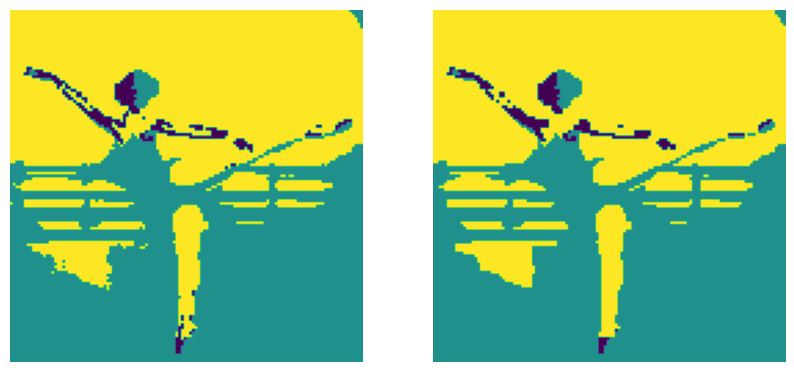


lambda :  0.1
Done in 0.03824140699998679 s


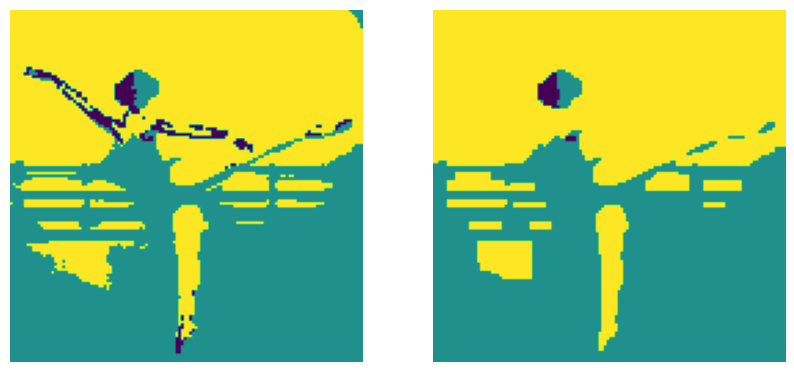


lambda :  1
Done in 0.047706158999972104 s


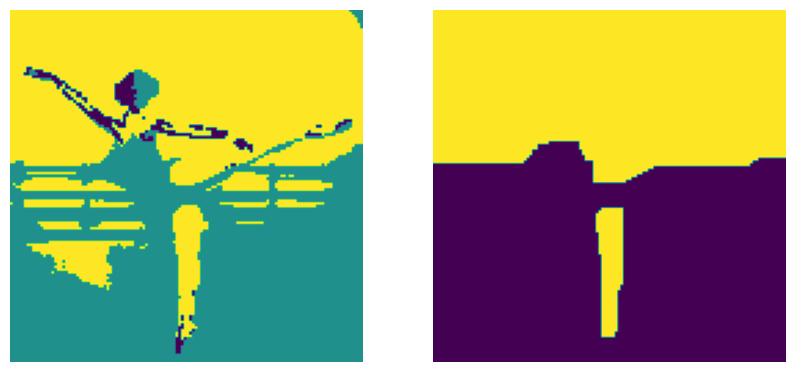

In [31]:
#pymaxflow

for lambd in [1e-2,1e-1,1]:
  print("")
  print("lambda : ", lambd)

  smooth_term = lambd * (1 - np.eye(n_clusters))
  data_term = distance_array.copy().astype(np.double)

  t1 = perf_counter()
  labels = aexpansion_grid(data_term, smooth_term, max_cycles=None)
  t2 = perf_counter()
  print(f"Done in {(t2-t1)} s")

  plot_2_images(greedy_assignments, labels)


method :  default


  0%|          | 0/9 [00:00<?, ?it/s]

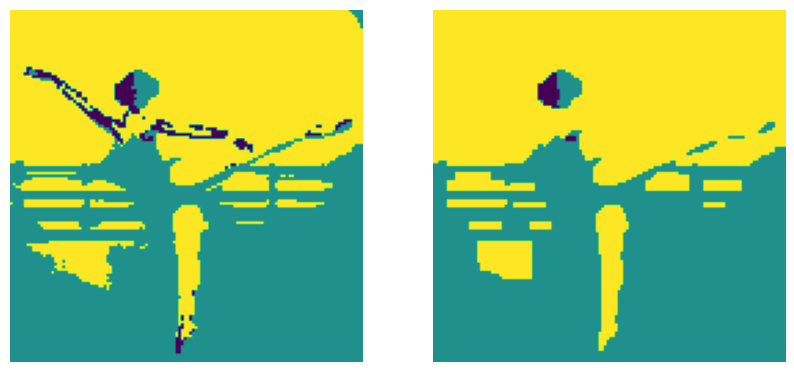

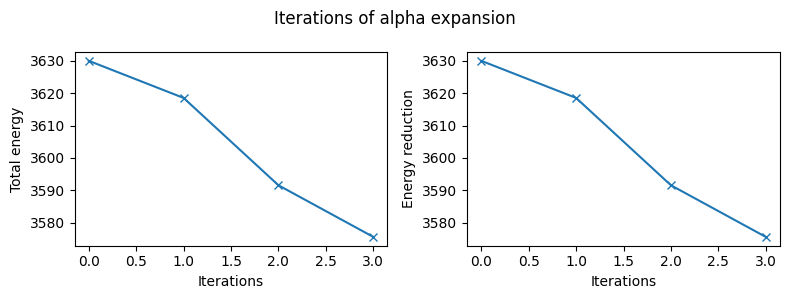


method :  shortest_path


  0%|          | 0/9 [00:00<?, ?it/s]

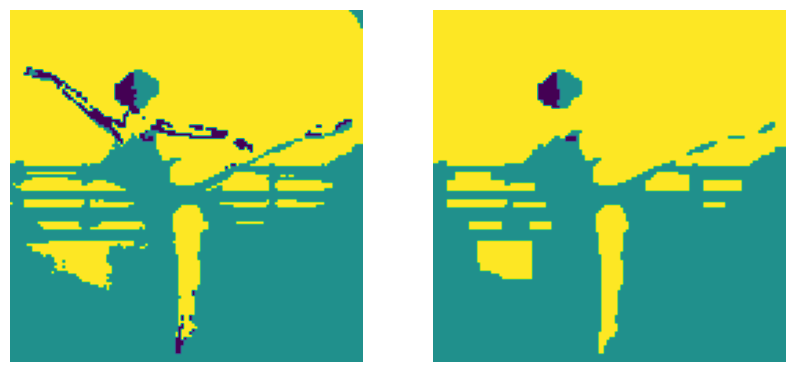

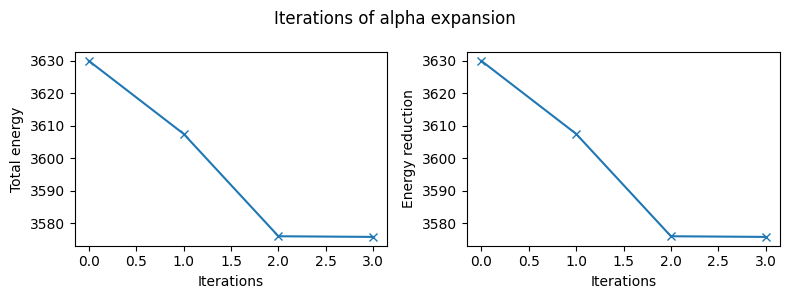


method :  igraph


  0%|          | 0/9 [00:00<?, ?it/s]

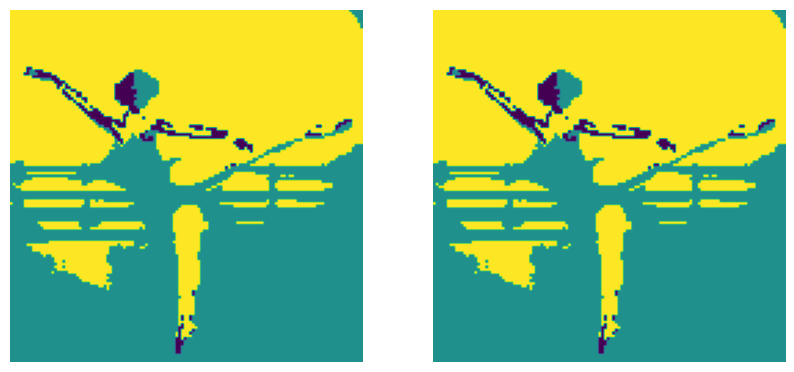

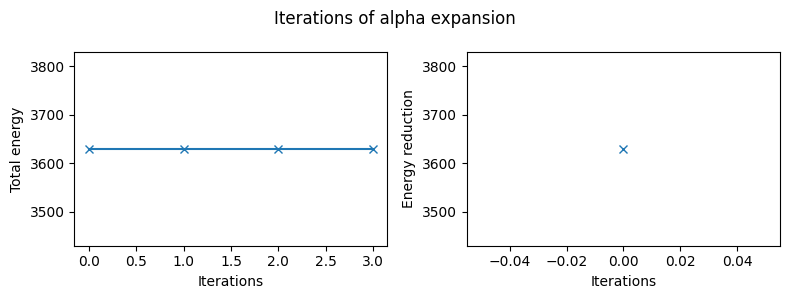

In [32]:
#various graph cuts methods for our own alpha expanson
lambd = 1e-1
max_cycles = 10

for method in ["default","shortest_path","igraph"]:
  print("")
  print("method : ", method)

  assignments, energies, computed_energies = gc.alpha_expansion(distance_array, greedy_assignments, max_cycles=3, lambd=lambd, method=method)

  plot_2_images(greedy_assignments, assignments)
  gc.plot_energy(energies, computed_energies)

## Style transfer onf RGB space

Content feature shapes :  (3, 128, 128)
Style feature shapes :  (3, 128, 128)
Cluster centers shape :  (3, 3)


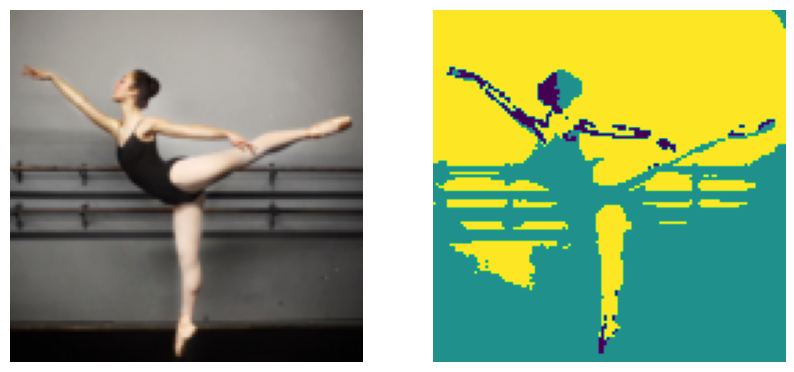

In [35]:
content_features = content_img.transpose(2,0,1)
content_shape = content_features.shape # (channel, height, width)
style_features = style_img.transpose(2,0,1)
print("Content feature shapes : ",content_features.shape)
print("Style feature shapes : ",style_features.shape)
cluster_centers, cluster_list, cluster_labels = cluster_style(style_features, k = n_clusters)
print("Cluster centers shape : ",cluster_centers.shape)
distance_array = data_energy(content_features, cluster_centers, distance="euclidean")
greedy_assignments = np.argmin(distance_array,axis=2)
plot_2_images(content_img,greedy_assignments)

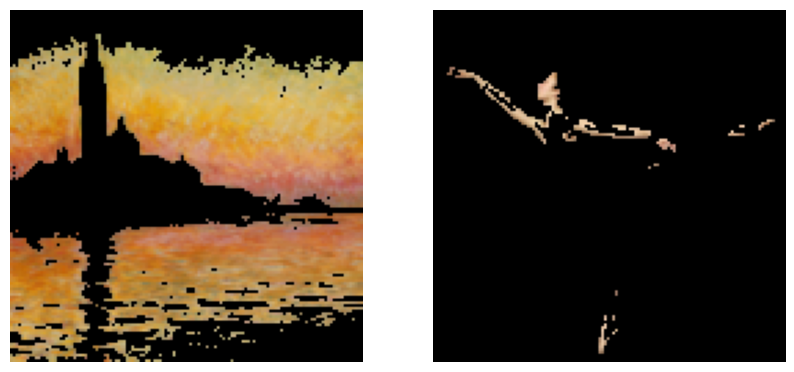

In [50]:
mask = (greedy_assignments == 0)
content_cluster__img = np.zeros((imsize,imsize,3),dtype=np.float32)
content_cluster__img[mask] = content_img[mask][:]

mask = (cluster_labels.reshape((imsize,imsize)) == 0)
style_cluster__img = np.zeros((imsize,imsize,3),dtype=np.float32)
style_cluster__img[mask]  = style_img[mask][:]

plot_2_images(style_cluster__img, content_cluster__img)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



Distance :  cosine
Transfered features shape :  torch.Size([3, 128, 128])


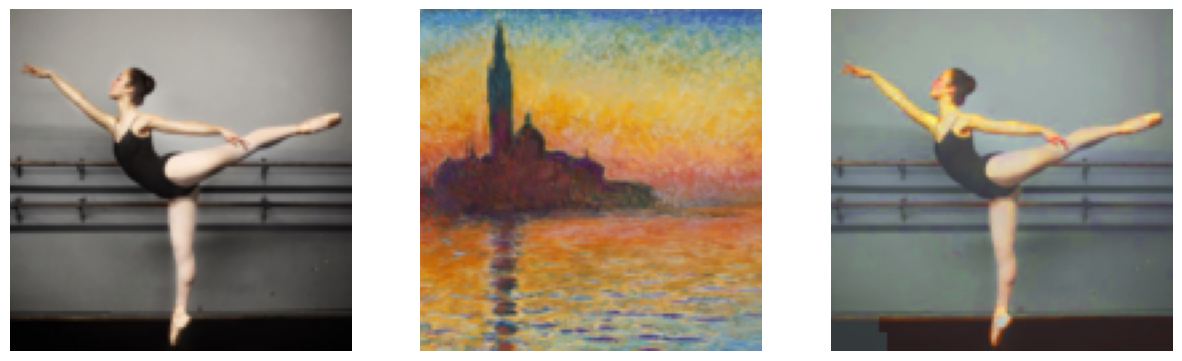


Distance :  euclidean
Transfered features shape :  torch.Size([3, 128, 128])


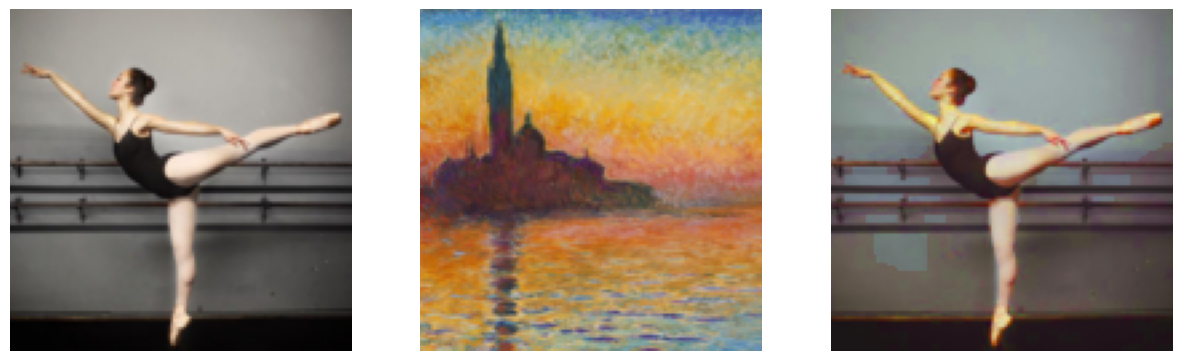

In [51]:
#pymaxflow with euclidiean dist

for distance in ["cosine","euclidean"]:
  print("")
  print("Distance : ",distance)
  transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=0.5, lambd=0.1, k=3, distance=distance)
  print("Transfered features shape : ",transfered_features.shape)
  plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())

bon ça se remet à pas marcher lol mais dtf on change le repo donc balec


Alpha :  0.1
Transfered features shape :  torch.Size([3, 128, 128])


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


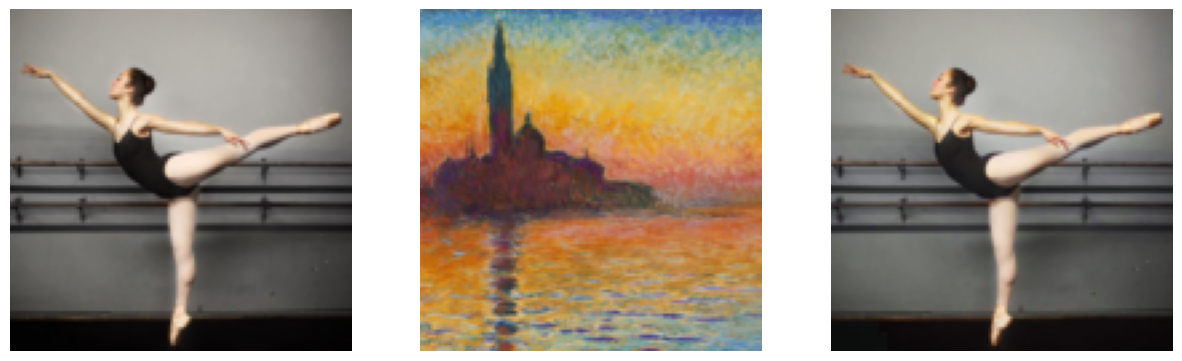


Alpha :  0.2
Transfered features shape :  torch.Size([3, 128, 128])


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


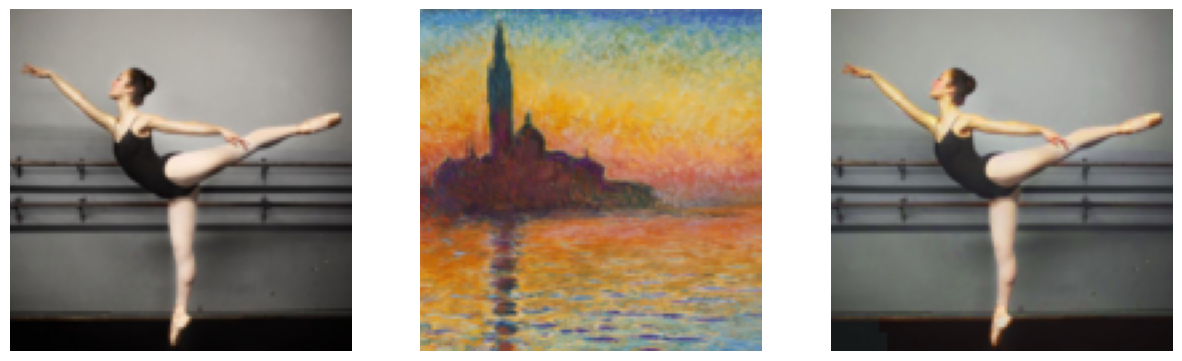

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



Alpha :  0.5
Transfered features shape :  torch.Size([3, 128, 128])


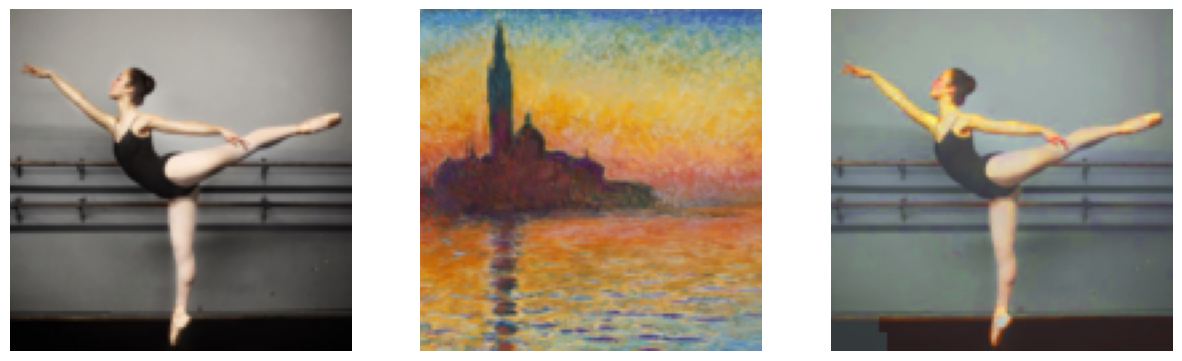

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



Alpha :  0.8
Transfered features shape :  torch.Size([3, 128, 128])


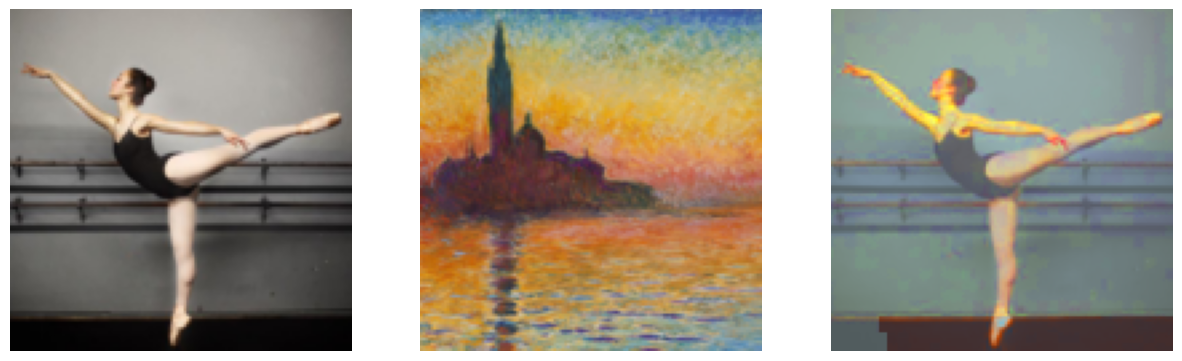

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(



Alpha :  1
Transfered features shape :  torch.Size([3, 128, 128])


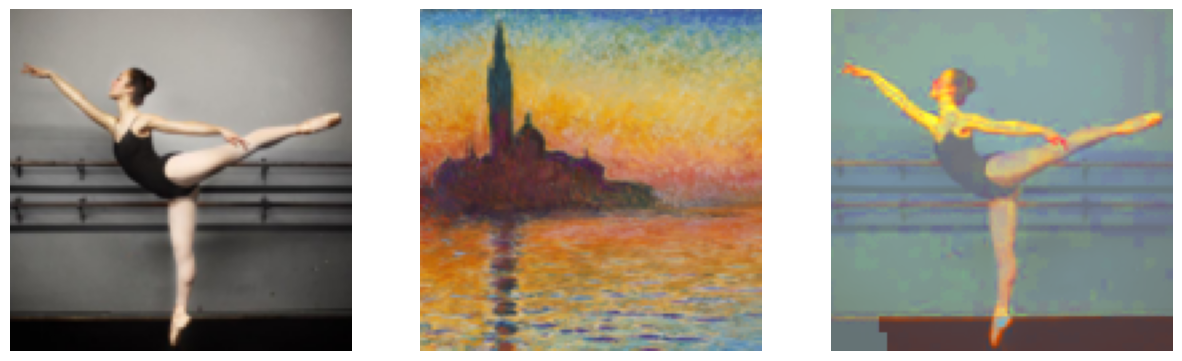

In [52]:
#pymaxflow with different alphas
for alpha in [0.1,0.2,0.5,0.8,1]:
  print("")
  print("Alpha : ",alpha)
  transfered_features = style_transfer(content_img.transpose(2,0,1), style_img.transpose(2,0,1), alpha=alpha, lambd=0.1, k=3)
  print("Transfered features shape : ",transfered_features.shape)
  plot_3_images(content_img, style_img, transfered_features.permute(1,2,0).cpu().numpy())